# **Fashion MNIST Image Classification Using CNN with PyTorch**

In this project, we will classify Fashion-MNIST dataset using Convolutional Neural Networks.</p>

## Import Necessary Libraries

In [1]:
# !pip install torch
# !pip install torchvision

In [2]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU:", torch.cuda.get_device_name(0))

GPU: NVIDIA GeForce GTX 1660 SUPER


In [4]:
# Function for showing the image

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy(), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## Prepare Dataset

Use `Compose` to create a transform to resize the image and convert it to a tensor

In [5]:
composed = transforms.Compose([transforms.ToTensor()])

Create two dataset objects for the Fashion MNIST  dataset. One for training data called `dataset_train` and one for validation data `dataset_val`

In [6]:
dataset_train = dsets.FashionMNIST(root= '.fashion/data', train=True, transform=composed, download=True)
dataset_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .fashion/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [7]:
dataset_val = dsets.FashionMNIST(root= '.fashion/data', train=False, transform=composed, download=True)
dataset_val

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: .fashion/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

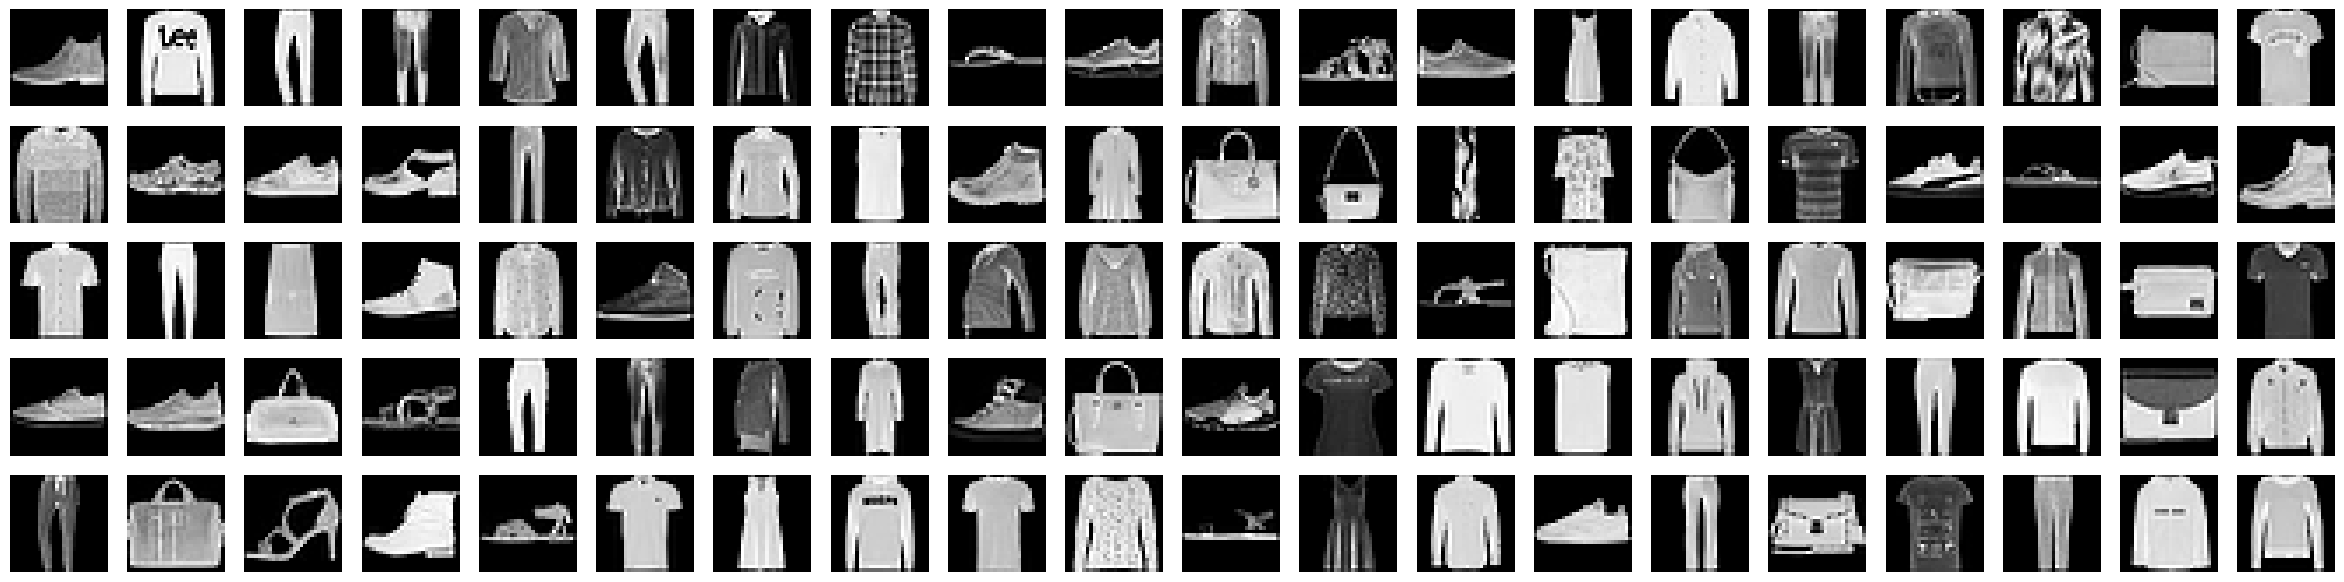

In [8]:
plt.figure(figsize=(30,30))
for i in range(100):
    plt.subplot(20, 20, i+1)
    plt.imshow(dataset_val[i][0].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

## Create Convolutional Neural Network Class

Constructor  for regular Convolutional Neural Network

In [9]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1, out_2, number_of_classes):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_2*6*6, 600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)

        return x

Train loader  and validation loader 

In [10]:
train_loader = DataLoader(dataset=dataset_train, batch_size=100)
test_loader = DataLoader(dataset=dataset_val, batch_size=100)

Creating a model for CNN class

In [11]:
model = CNN(out_1=32, out_2=64,number_of_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
print(model)

CNN(
  (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


## Model Training

In [12]:
cost_list = []
accuracy_list = []
N_test = len(dataset_val)
n_epochs = 20

# Train the model
for epoch in range(n_epochs):
    cost = 0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost += loss.item()
    correct = 0

    # Perform prediction on the validation data 
    model.eval()
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test.to(device)).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)

## Model Evaluation

Plot cost and accuracy

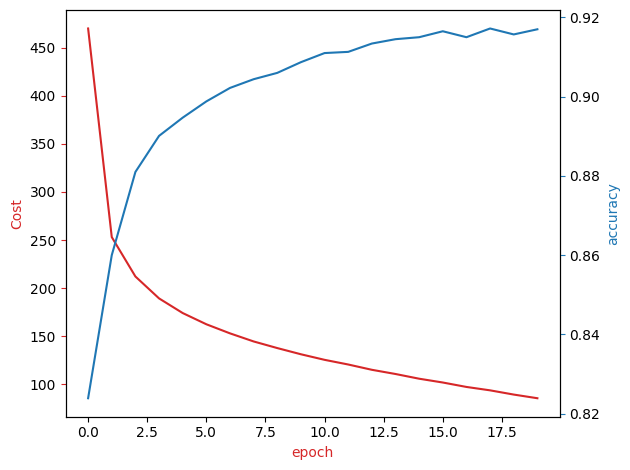

In [13]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

Print classification report

In [14]:
model.eval()
y_pred = []
y_true = []

for x_test, y_test in test_loader:
    x_test = x_test.to(device)
    z = model(x_test)
    _, yhat = torch.max(z.data, 1)
    y_pred.extend(yhat.cpu().numpy())
    y_true.extend(y_test.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       0.99      0.97      0.98      1000
           2       0.87      0.88      0.87      1000
           3       0.89      0.95      0.92      1000
           4       0.88      0.86      0.87      1000
           5       0.99      0.97      0.98      1000
           6       0.79      0.73      0.76      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Display confusion matrix

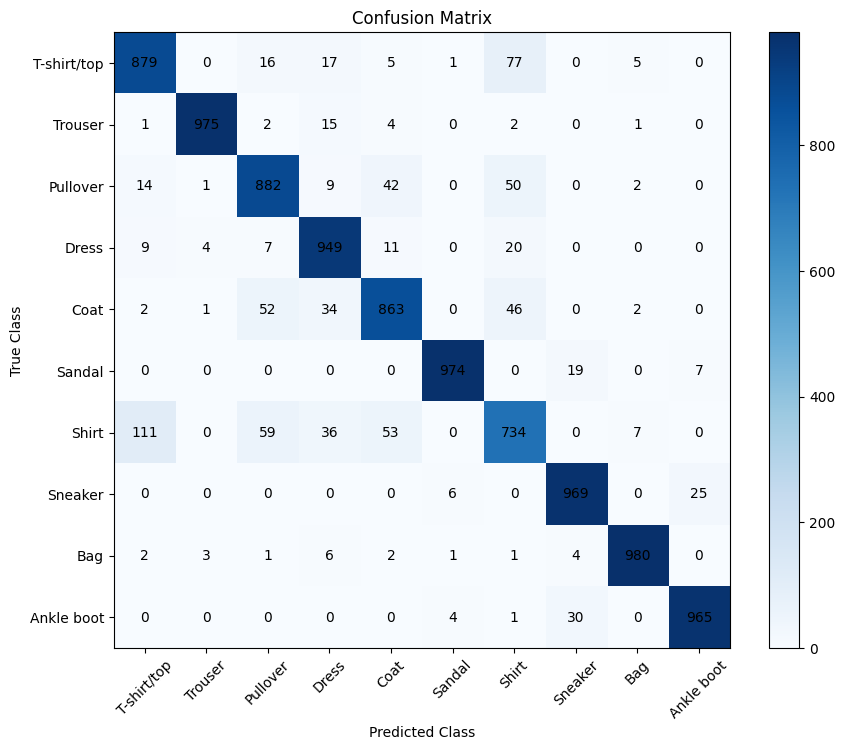

In [15]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

tick_marks = np.arange(len(dataset_val.classes))
plt.xticks(tick_marks, dataset_val.classes, rotation=45)
plt.yticks(tick_marks, dataset_val.classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


dataset: https://github.com/zalandoresearch/fashion-mnist

## Export Trained Model

In [16]:
torch.save(model, 'models/fashion_cnn_pytorch.pt')